In [37]:


import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, precision_score, recall_score, accuracy_score, confusion_matrix
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras.applications.xception import Xception
from keras.applications import *
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from PIL import Image
import random
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier 
from keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.decomposition import PCA
from tensorflow.keras.utils import to_categorical



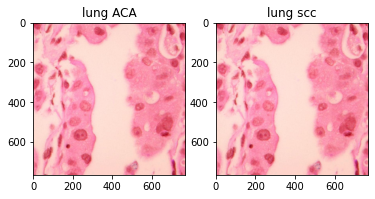

In [38]:
colon_aca = "../input/lung-cancer/lung_image_small/lung_aca/"

plt.subplot(121)
img = cv2.imread(colon_aca + os.listdir(colon_aca)[0])
plt.title('lung ACA')
plt.imshow(img)

plt.subplot(122)
colon_n = "../input/lung-cancer/lung_image_small/lung_aca/"
img = cv2.imread(colon_n + os.listdir(colon_n)[0])
plt.title('lung N')
plt.imshow(img)

plt.subplot(122)
colon_n = "../input/lung-cancer/lung_image_small/lung_aca/"
img = cv2.imread(colon_n + os.listdir(colon_n)[0])
plt.title('lung scc')
plt.imshow(img)
plt.show()

In [39]:
data_dir = "../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/"

SIZE_X = SIZE_Y = 128

datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.3)

train_it = datagen.flow_from_directory(data_dir,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X,SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 12, 
                                       shuffle = False,
                                       subset='training',
                                       seed = 42)

validate_it = datagen.flow_from_directory(data_dir,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X, SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 12, 
                                       shuffle = False,
                                       subset='validation',
                                       seed = 42)

Found 10500 images belonging to 3 classes.
Found 4500 images belonging to 3 classes.


In [40]:
def fit_model(model, train_it, validate_it, epochs = 10):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    
    for layer in model.layers:
        layer.trainable = False
    
    flat1 = Flatten()(model.layers[-1].output)
    output = Dense(len(train_it.class_indices), activation='softmax')(flat1)
    
    model = Model(inputs=model.inputs, outputs=output)
    print(model.summary())
    
    model.compile(loss='categorical_crossentropy', optimizer ='adam', metrics=['accuracy'])

    history = model.fit(train_it, validation_data=validate_it, epochs=epochs, verbose=1, callbacks=[es])
    return model

# Inputx128x128x64x32x16x16xFlattenxOutput

In [41]:
def get_accuracy_metrics(model, train_it, validate_it):
    y_val = validate_it.classes
    
    val_pred_proba = model.predict(validate_it)
    
    val_pred_proba, predicted_proba, y_val, y_test = train_test_split(val_pred_proba, y_val, test_size = 0.5, shuffle = True)
    
    val_pred = np.argmax(val_pred_proba, axis = 1)
    predicted = np.argmax(predicted_proba, axis = 1)
    
    print("Train accuracy Score------------>")
    print ("{0:.3f}".format(accuracy_score(train_it.classes, np.argmax(model.predict(train_it), axis = 1))*100), "%")
    
    print("Val accuracy Score--------->")
    print("{0:.3f}".format(accuracy_score(y_val, val_pred)*100), "%")
    
    print("Test accuracy Score--------->")
    print("{0:.3f}".format(accuracy_score(y_test, predicted)*100), "%")
    
    print("F1 Score--------------->")
    print("{0:.3f}".format(f1_score(y_test, predicted, average = 'weighted')*100), "%")
    
    print("Cohen Kappa Score------------->")
    print("{0:.3f}".format(cohen_kappa_score(y_test, predicted)*100), "%")
    
    
    print("ROC AUC Score------------->")
    print("{0:.3f}".format(roc_auc_score(to_categorical(y_test, num_classes = 3), predicted_proba, multi_class='ovr')*100), "%")
    
    print("Recall-------------->")
    print("{0:.3f}".format(recall_score(y_test, predicted, average = 'weighted')*100), "%")
    
    print("Precision-------------->")
    print("{0:.3f}".format(precision_score(y_test, predicted, average = 'weighted')*100), "%")
    
    cf_matrix_test = confusion_matrix(y_test, predicted)
    cf_matrix_val = confusion_matrix(y_val, val_pred)
    
    plt.figure(figsize = (12, 6))
    plt.subplot(121)
    sns.heatmap(cf_matrix_val, annot=True, cmap='Blues')
    plt.title("Val Confusion matrix")
    
    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')
    plt.title("Test Confusion matrix")
    
    plt.show()

In [42]:
model = VGG19(include_top=False, input_shape=(SIZE_X, SIZE_Y, 3), weights='imagenet')
model = fit_model(model, train_it, validate_it)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

Train accuracy Score------------>
98.781 %
Val accuracy Score--------->
97.022 %
Test accuracy Score--------->
96.756 %
F1 Score--------------->
96.750 %
Cohen Kappa Score------------->
95.133 %
ROC AUC Score------------->
99.127 %
Recall-------------->
96.756 %
Precision-------------->
96.818 %


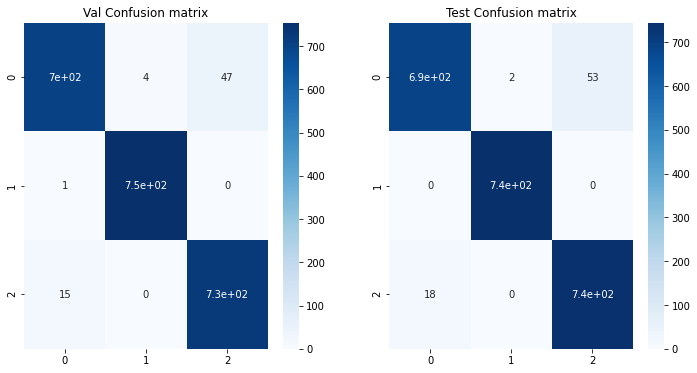

In [43]:
get_accuracy_metrics(model, train_it, validate_it)

In [45]:
model.save("mymodelVGG19_big.h5")